# 323-29 - COVID19-BR

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from glob import glob

## 0 - dados brutos

fonte = <https://data.brasil.io/dataset/covid19/caso_full.csv.gz>

In [109]:
# lendo arquivo
files = glob('0_bruto_*')
dados = pd.read_csv(files[-1],compression='gzip',encoding="UTF8")

# colunas
colunas_geral = ['last_available_confirmed','new_confirmed','place_type',
                 'state','city','date']

# criando dataframe e selecionando apenas algumas colunas
brutodf = pd.DataFrame(data=dados)
df = brutodf.filter(items=colunas_geral)
df.fillna(0)

# puxando dias corridos pela data e criando semana corrida
from datetime import date

df['data']=pd.to_datetime(df['date'])
df['dia_corrido'] = ( df['data'] - df['data'].min() ).dt.days
df['semana_corrida'] = df['dia_corrido'] // 7

# remove colunas de data que não precisa mais
df.drop('date',axis=1,inplace=True)
df.drop('data',axis=1,inplace=True)

# duplicando coluna de casos totais 
df['totais2'] = df['last_available_confirmed']

## 1.0.1 - processamento geral (novas bases)

In [110]:
# dados associando região com estado e região metropolitana com cidade
regiaoBR = pd.read_excel('0_dicionario.xlsx',sheet_name=0)
RM = pd.read_excel('0_dicionario.xlsx',sheet_name=1)

# acoplando essas informações nas tabelas de estado e cidade
df_Estado = df.loc[df['place_type'] == 'state']
df_Regiao_temp1 = df_Estado.merge(regiaoBR,on='state')
df_Cidade = df.loc[df['place_type'] == 'city']
df_RM_temp1 = df_Cidade.merge(RM,on='city')

In [111]:
# agrupando e somando por região e por RM criando nova tabela processada pra ambos
colunas = ['regiao','dia_corrido','semana_corrida']
agregando = {'new_confirmed':'sum','last_available_confirmed':'sum','totais2':'sum'} 

df_Regiao = df_Regiao_temp1.groupby( colunas )\
            .agg( agregando )\
            .reset_index()\
            .sort_values( by=['regiao','dia_corrido'], ascending=True )

colunas[0] = 'RM'
df_RM = df_RM_temp1.groupby( colunas )\
            .agg( agregando )\
            .reset_index()\
            .sort_values( by=['RM','dia_corrido'],ascending=True )

# lista de arquivos para processamento final
listaDF = [df_Estado,df_Cidade,df_Regiao,df_RM]

## 1.0.2 - processamento final (casos por semana X casos totais)

In [112]:
def processa_e_grafico(UnidadeFederativa,DataFrameGeral,ListaLugares):       
    # cria gráfico
    fig1, ax1 =  plt.subplots(figsize=(15,8))
    
    ## cria linha-base de duplicar casos todo dia (exponencial puro)
    ax1.plot(DataFrameGeral['last_available_confirmed'],DataFrameGeral['totais2'],color='k')

    ## cria tabelas e linhas de cada lugar escolhido
    for item in ListaLugares:
        temp = DataFrameGeral[ DataFrameGeral[ UnidadeFederativa ] == item ].copy()
        temp['novo_semanal_diario'] = temp['new_confirmed'].rolling(7,min_periods=1).sum()
        temp['novo_semanal'] = temp['novo_semanal_diario'].rolling(7,min_periods=1).mean()
        temp.set_index('dia_corrido',inplace=True)
        
        ax1.plot( temp.totais2, temp.novo_semanal, label = item  )

    ## transforma em bilog
    plt.loglog()
    
    plt.grid(True)
    
    ## nomes dos eixos
    ax1.set_ylabel('casos novos por semana',fontsize=16)
    ax1.set_xlabel('casos totais',fontsize=16)
    for axis in [ax1.xaxis, ax1.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

    ## legenda no canto superior esquerdo ancorado pelo vértice superior esquerdo
    if UnidadeFederativa == 'RM':
        ax1.legend(bbox_to_anchor=(0.05,0.90),loc=2,borderaxespad=0.,fontsize=12,ncol=1)
        
    else:
        ax1.legend(bbox_to_anchor=(0.05,0.90),loc=2,borderaxespad=0.,fontsize=12,ncol=3)

## 1.1 + 2.1 - info por estado

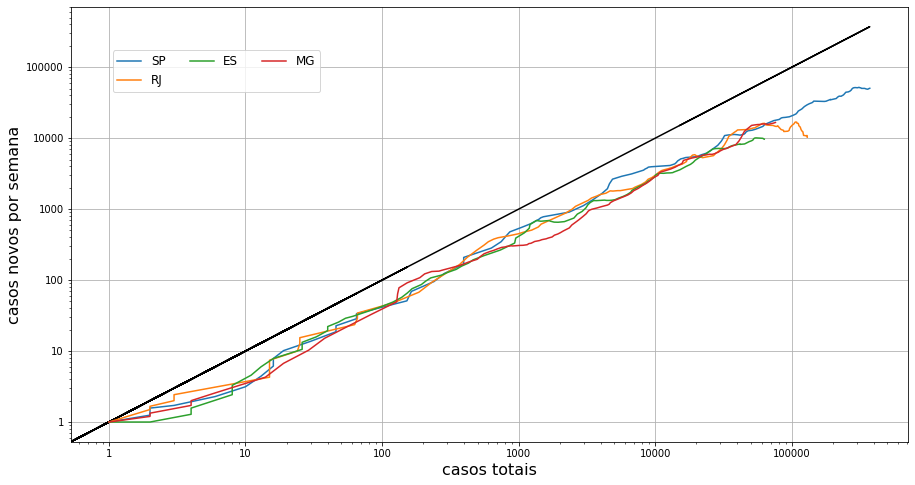

In [113]:
# puxando lista de estados e selecionando os que vão aparecer no gráfico
listaEstados = df['state'].drop_duplicates()
listaEstados = ['SP','RJ','ES','MG']
processa_e_grafico('state',listaDF[0],listaEstados)

## 1.2 + 2.2 - processamento e geração de informação por região do Brasil

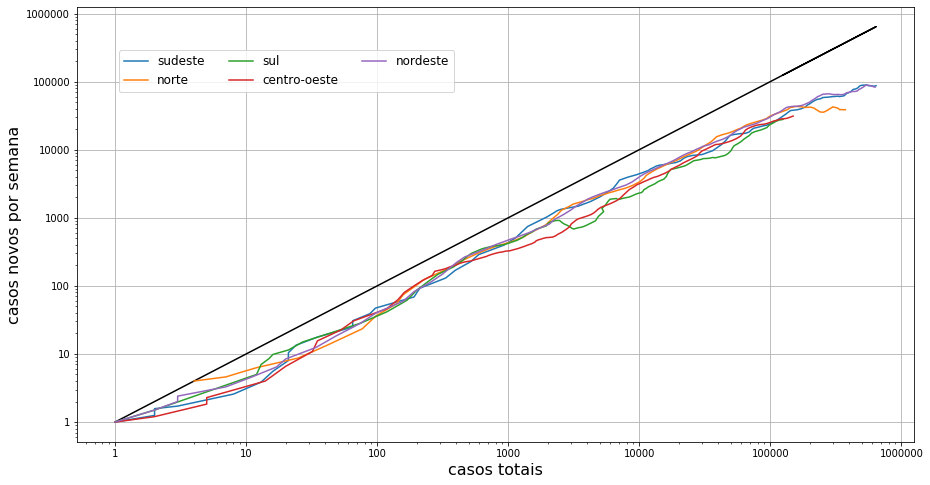

In [114]:
# puxando lista de regiões e selecionando os que vão aparecer no gráfico
listaRegiao = ['sudeste','norte','sul','centro-oeste','nordeste']
processa_e_grafico('regiao',listaDF[2],listaRegiao)

## 1.3 + 2.3 - processamento e geração de informação por município

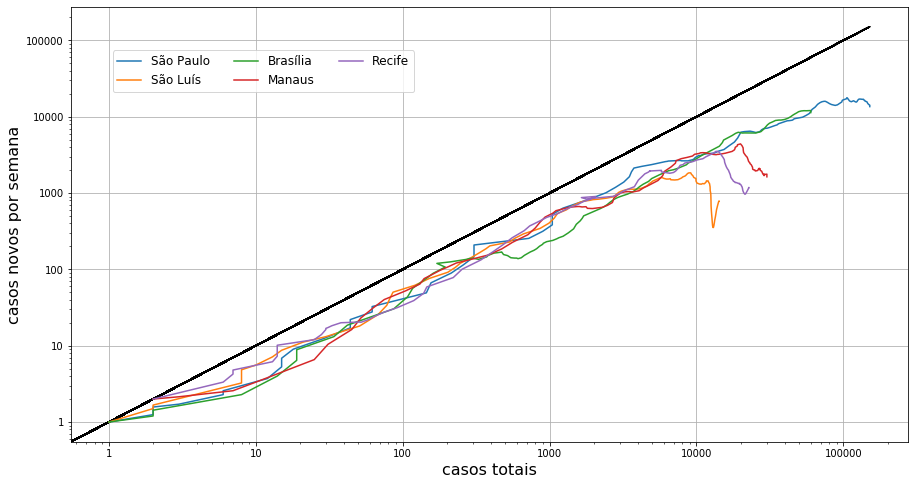

In [115]:
# puxando lista de municípios e selecionando os que vão aparecer no gráfico
listaCidades = df['city'].drop_duplicates()
listaCidades = ['São Paulo','São Luís','Brasília','Manaus','Recife']
processa_e_grafico('city',listaDF[1],listaCidades)

## 1.4 + 2.4 - processamento e geração de informação por região metropolitana

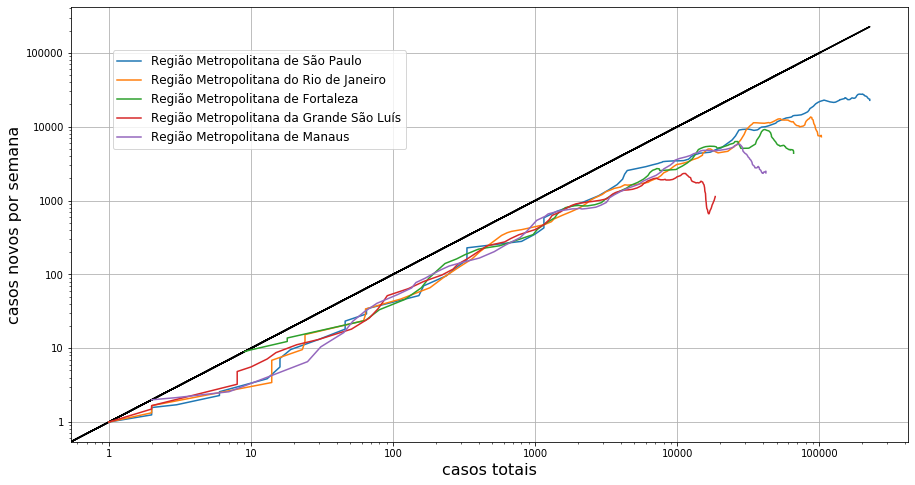

In [116]:
# puxando lista de regiões e selecionando os que vão aparecer no gráfico
listaRM = ['Região Metropolitana de São Paulo',
           'Região Metropolitana do Rio de Janeiro',
           'Região Metropolitana de Fortaleza',
           'Região Metropolitana da Grande São Luís',
           'Região Metropolitana de Manaus']

#listaRM = ['Região Metropolitana de São Paulo','Região Metropolitana de Sorocaba','Região Metropolitana de Campinas','Região Metropolitana do Vale do Paraíba e Litoral Norte','Região Metropolitana de Ribeirão Preto']

#lista = df_RM['RM'].drop_duplicates()
#for item in lista:
#    print(item)
    
processa_e_grafico('RM',listaDF[3],listaRM)